## Framing

Considering an audio file, framing consists in splitting the signal into short,
possibly overlapping windows and computing features on each window separately.
In this example we use a frame length of **23 ms** at a sampling rate of **16 kHz**
and a **50% overlap** between consecutive frames.

Frame-level features (e.g. MFCC, DFB, OSC) provide a detailed time–frequency
representation of the signal, but computing them for every frame of every track
in the dataset would be computationally expensive and generate very large feature
matrices.

For this reason, in the final pipeline we use framing mainly for analysis and
visualization, while feature extraction for the models is applied at the
segment level (3-second chunks) instead of at every single frame.


In [53]:
import numpy as np
import librosa
import matplotlib.pyplot as plt


In [54]:
sample_rate=16000
frame_length = int(0.023 * sample_rate)  # 23ms
hop_length = frame_length // 2  # 50% overlap
n_bands=20

audio, sr = librosa.load("Data/genres_original/blues/blues.00000.wav", sr=sample_rate, mono=True)
framed_audio = librosa.util.frame(audio, frame_length=frame_length, hop_length=hop_length)
framed_audio.shape

(368, 2608)

## MFCC

MFCCs (Mel-Frequency Cepstral Coefficients) are a compact representation of the
short-term spectral envelope of the signal. Here we compute MFCCs for each
frame of the framed audio and visualize how they evolve over time.


Shape of MFCCs array: (20, 2608)


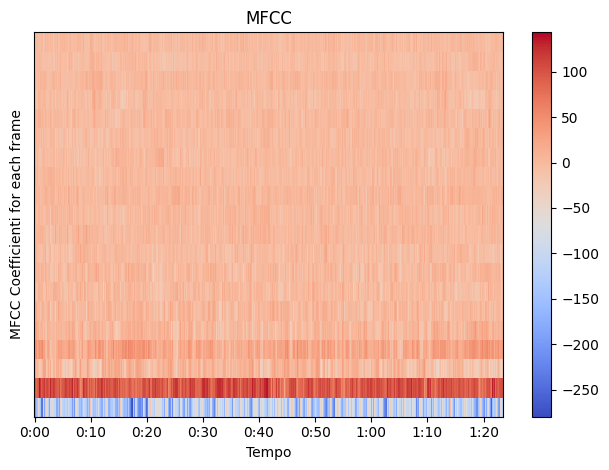

In [55]:
audio_mfcc_features=[]

for frame in framed_audio.T:
    mfcc = librosa.feature.mfcc(y=frame, sr=sr, n_mfcc=n_bands)
    mfcc = mfcc.flatten()
    audio_mfcc_features.append(mfcc)

audio_mfcc_features = np.array(audio_mfcc_features).T

print("Shape of MFCCs array:", audio_mfcc_features.shape) 

librosa.display.specshow(audio_mfcc_features, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.xlabel('Tempo')
plt.ylabel('MFCC Coefficienti for each frame')
plt.tight_layout()
plt.show()

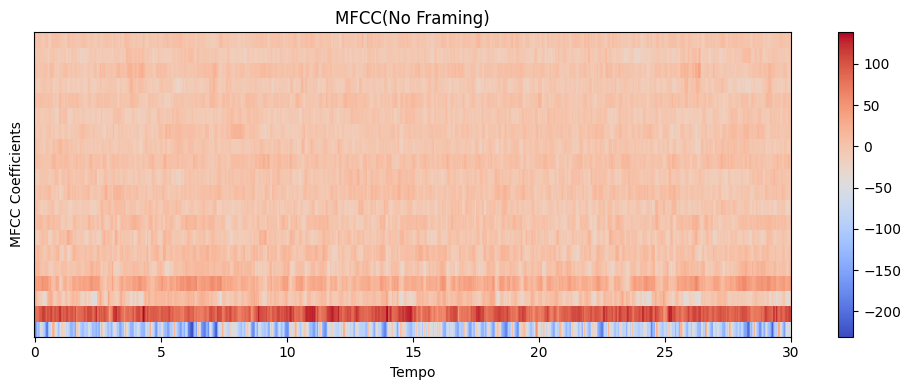

In [56]:

mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC(No Framing)')
plt.xlabel('Tempo')
plt.ylabel('MFCC Coefficients')
plt.tight_layout()
plt.show()

## OSC

OSC (Octave-based Spectral Contrast) describes the relative energy between peaks
and valleys in different frequency bands. It highlights differences between
harmonic and noisy components and is useful to discriminate between music genres.


Shape of MFCCs array: (7, 2608)


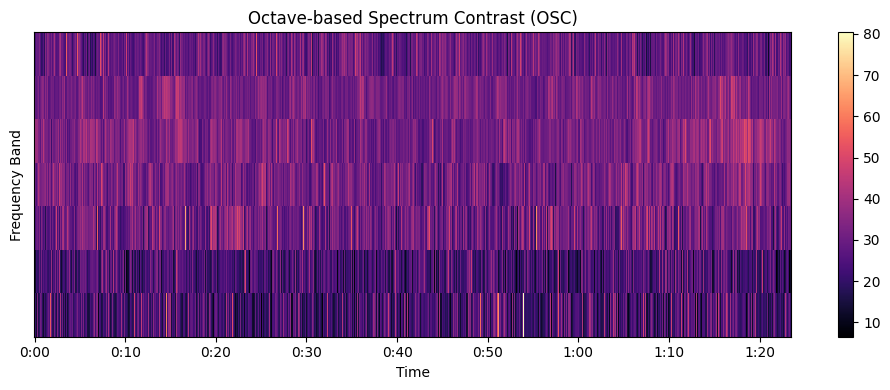

In [57]:
audio_osc_features=[]
    
for frame in framed_audio.T:
    spec_power = np.abs(librosa.stft(frame))**2    
    osc = librosa.feature.spectral_contrast(S=spec_power, sr=sr)
    osc = osc.flatten()
    audio_osc_features.append(osc)

audio_osc_features = np.array(audio_osc_features).T

print("Shape of MFCCs array:", audio_osc_features.shape) 

plt.figure(figsize=(10, 4))
librosa.display.specshow(audio_osc_features, sr=sr, x_axis='time')
plt.colorbar()
plt.title('Octave-based Spectrum Contrast (OSC)')
plt.xlabel('Time')
plt.ylabel('Frequency Band')
plt.tight_layout()
plt.show()

(7, 938)


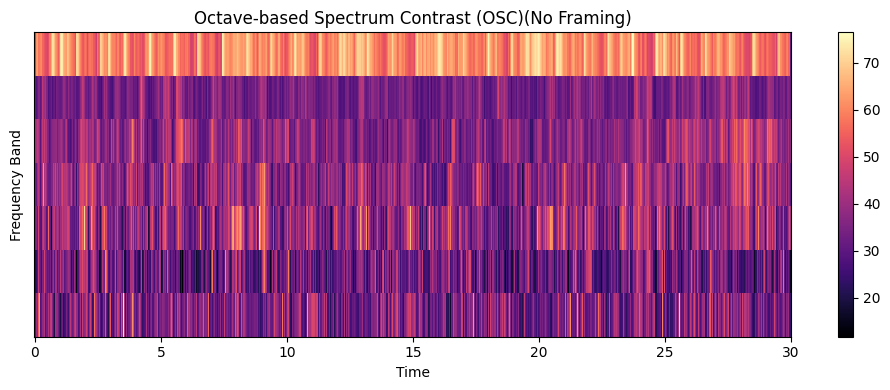

In [58]:
spec_power = np.abs(librosa.stft(audio))**2

osc = librosa.feature.spectral_contrast(S=spec_power, sr=sr)
print(osc.shape)

plt.figure(figsize=(10, 4))
librosa.display.specshow(osc, sr=sr, x_axis='time')
plt.colorbar()
plt.title('Octave-based Spectrum Contrast (OSC)(No Framing)')
plt.xlabel('Time')
plt.ylabel('Frequency Band')
plt.tight_layout()
plt.show()

## DFB

The Decorrelated Filter Bank (DFB) features are obtained by passing the signal
through a bank of band-pass filters and decorrelating the resulting outputs.
In this notebook we compare DFB features computed on framed audio with those
computed directly on the original (unframed) signal.


In [59]:
# Frame the audio using a 23 ms Hamming window with a 50% overlap
framed_audio = librosa.util.frame(audio, frame_length=frame_length, hop_length=hop_length).T

# Apply Hamming window to each frame
hamming_window = np.hamming(frame_length)
windowed_frames = framed_audio * hamming_window

In [60]:
# Define the decorrelated_filter_bank function
def decorrelated_filter_bank(frame, sr, n_bands, hop_length):
    mel_spec = librosa.feature.melspectrogram(y=frame, sr=sr, hop_length=hop_length, n_mels=n_bands)
    log_mel_spectrogram = librosa.power_to_db(mel_spec, ref=np.max)
    dfb = np.diff(log_mel_spectrogram, axis=0)
    return dfb

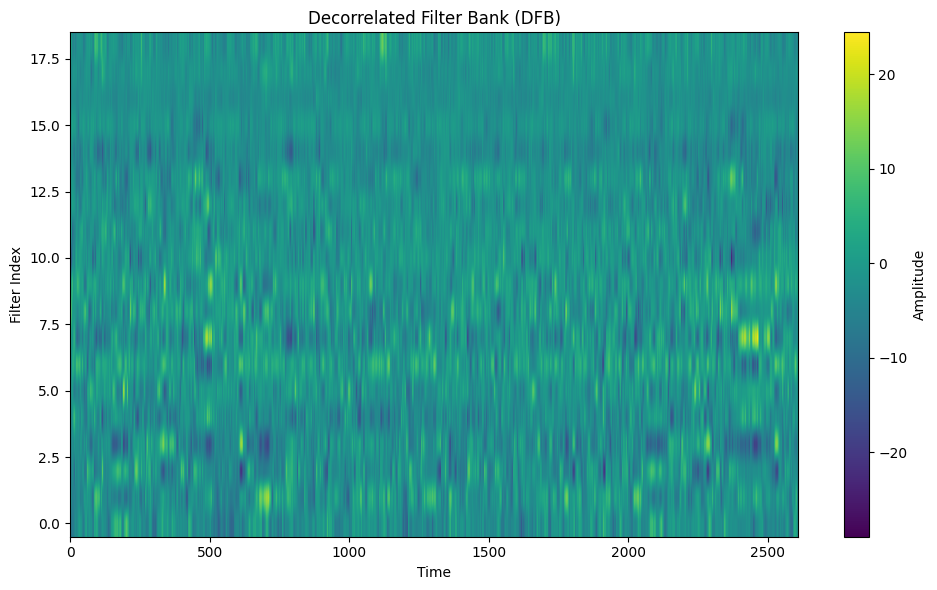

In [61]:
# Apply DFB to each frame and collect the features
audio_dfb_features = []

for frame in windowed_frames:
    dfb = decorrelated_filter_bank(frame, sr, n_bands, hop_length)
    dfb = np.mean(dfb, axis=1)
    audio_dfb_features.append(dfb)

# Convert list to numpy array for visualization
audio_dfb_features = np.array(audio_dfb_features).T

# Plot the DFB features
plt.figure(figsize=(10, 6))
plt.imshow(audio_dfb_features, cmap='viridis', aspect='auto', origin='lower')
plt.colorbar(label='Amplitude')
plt.title('Decorrelated Filter Bank (DFB)')
plt.xlabel('Time')
plt.ylabel('Filter Index')
plt.tight_layout()
plt.show()

In [62]:
def decorrelated_filter_bank(signal, sample_rate, n_bands):
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=n_bands)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    dfb = np.diff(log_mel_spectrogram, axis=0)
    return dfb

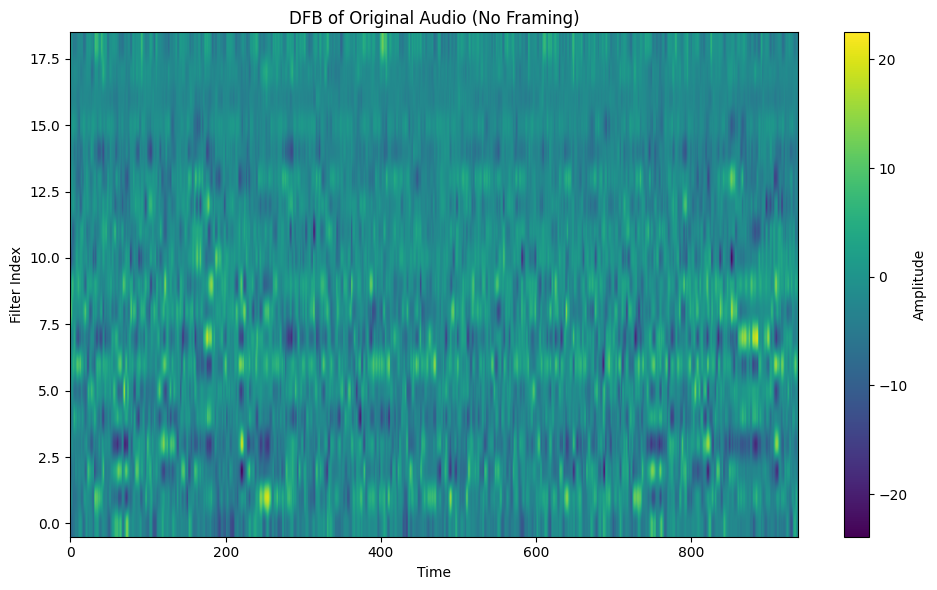

In [63]:
# Apply DFB to the original audio (without framing)
dfb_original = decorrelated_filter_bank(audio, sample_rate, n_bands=20)
# Plot the DFB features
plt.figure(figsize=(10, 6))
plt.imshow(dfb_original, cmap='viridis', aspect='auto', origin='lower')
plt.colorbar(label='Amplitude')
plt.title('DFB of Original Audio (No Framing)')
plt.xlabel('Time')
plt.ylabel('Filter Index')
plt.tight_layout()
plt.show()